<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/JaxPM/blob/main/notebooks/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.80' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap
import jax_cosmo as jc
from jax.experimental.ode import odeint

from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, make_ode_fn
from montecosmo.bricks import lpt as mylpt, Planck18
from montecosmo.models import get_pk_fn

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("2LPT")

feynmangpu04.cluster.local
gpu


2024-07-30 23:00:50.570284: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


<Experiment: artifact_location='mlflow-artifacts:/547104511832230362', creation_time=1722329483954, experiment_id='547104511832230362', last_update_time=1722329483954, lifecycle_stage='active', name='2LPT', tags={}>

In [16]:
mesh_length = 256
mesh_shape = mesh_length*np.array([1,1,1])
box_shape  = np.array([640.,640.,640.])
n_snapshots = 2
rsd = True
a_lpt, a_obs = 0.1, 1.

multipoles = [0,2,4]
pk_fn = get_pk_fn(mesh_shape, box_shape, multipoles=multipoles)
zeros_mesh = jnp.zeros(mesh_shape)

def run_simulation(cosmology, a_lpt=1., a_obs=1., lpt_order=1):
    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))

    # Initial displacement
    particles = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}  # FIX ME: this a temporary fix
    dx, p, f = mylpt(cosmology, initial_conditions, particles, a_lpt, lpt_order)
    # return dx, p
    if a_obs == a_lpt:
        pos = particles + dx
    else:
        # Evolve the simulation forward
        snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
        res = odeint(make_ode_fn(mesh_shape), jnp.stack([particles+dx, p]), snapshots, cosmology, rtol=1e-5, atol=1e-5)
        pos = res[-1,0]
        p = res[-1,1]

    if rsd:        
        dx_rsd = p / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        return cic_paint(zeros_mesh, pos + dx_rsd * jnp.array([0,0,1]))
    else:
        return cic_paint(zeros_mesh, pos)

In [17]:
cosmology = Planck18()
print(f"Fiducial {cosmology}")
res = jit(partial(run_simulation, a_lpt=a_obs, a_obs=a_obs, lpt_order=1))(cosmology)
pk_jlpt1 = pk_fn(compensate_cic(res))
res = jit(partial(run_simulation, a_lpt=a_obs, a_obs=a_obs, lpt_order=2))(cosmology)
pk_jlpt2 = pk_fn(compensate_cic(res))
res = jit(partial(run_simulation, a_lpt=a_lpt, a_obs=a_obs, lpt_order=1))(cosmology)
pk_jpm1 = pk_fn(compensate_cic(res))
res = jit(partial(run_simulation, a_lpt=a_lpt, a_obs=a_obs, lpt_order=2))(cosmology)
pk_jpm2 = pk_fn(compensate_cic(res))
del res

from montecosmo.bricks import linear_pk_interp
pk_lin_obs = jnp.array([pk_jlpt1[0], linear_pk_interp(cosmology, a=a_obs)(pk_jlpt1[0])])

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102


In [15]:
from pmwd import Configuration, Cosmology, SimpleLCDM,\
    boltzmann, linear_power, growth, white_noise, linear_modes, nbody, lpt
import jax
from jaxpm.growth import growth_factor

ptcl_spacing = 640 / mesh_length # Mpc/h
ptcl_grid_shape = (mesh_length,)*3

def run_pmwd(a_lpt=1., a_obs=1., lpt_order=1):
    jax.config.update("jax_enable_x64", True)
    conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=lpt_order,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1e-3)
    cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    # XXX: sigma8 redshift dependant???
    # cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
    cosmo = boltzmann(cosmo, conf)
    # print(cosmo, conf)

    # Create a small function to generate the matter power spectrum
    k = jnp.logspace(-4, 1, 128)
    pk = jc.power.linear_matter_power(cosmology, k)
    pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)
    initial_conditions = linear_field(mesh_shape, box_shape, pk_fn, seed=jr.key(0))
    init_modes = jnp.fft.rfftn(initial_conditions)
    init_modes *= growth_factor(cosmology, jnp.atleast_1d(a_lpt)) / growth(a_lpt, cosmo, conf, order=1) * conf.ptcl_cell_vol
    # return lpt(init_modes, cosmo, conf)
    ptcl, obsvbl = lpt(init_modes, cosmo, conf)
    # return ptcl.disp/ptcl_spacing

    # modes = white_noise(0, conf)
    # field = jr.normal(jr.key(0), mesh_shape)
    # modes = jnp.fft.rfftn(field, norm="ortho")
    # modes = linear_modes(modes, cosmo, conf)        
    # ptcl, obsvbl = lpt(modes, cosmo, conf)
    
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    jax.config.update("jax_enable_x64", False)
    # particles = jnp.indices(mesh_shape).reshape(3,-1).T
    # return cic_paint(zeros_mesh, particles + ptcl.disp/ptcl_spacing)
    if rsd:
        dx_rsd = ptcl.vel / (jnp.sqrt(jc.background.Esqr(cosmology, a_obs)) * a_obs**2)
        pos = ptcl.pos() + dx_rsd * jnp.array([0,0,1])
    else:
        pos = ptcl.pos()
    
    # return scatter(ptcl, conf)
    return cic_paint(zeros_mesh, pos/ptcl_spacing)

In [5]:
from jaxpm.growth import growth_factor, growth_rate, dGfa, growth_factor_second, growth_rate_second, dGf2a
cosmology = Planck18()
print(f"Fiducial {cosmology}")
# a_lpt, a_obs = 0.1, 1.
a = jnp.atleast_1d(a_obs)
growth_jpm = jnp.concatenate([growth_factor(cosmology, a), 
                              3/7*growth_factor_second(cosmology, a)/ growth_factor(cosmology, a), 
                              growth_factor(cosmology, a)*growth_rate(cosmology, a), 
                              3/7*growth_factor_second(cosmology, a)*growth_rate_second(cosmology, a)/ growth_factor(cosmology, a)]) / growth_factor(cosmology, a)
print("jpm:", growth_jpm)

from pmwd.boltzmann import growth
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape=1, 
                         a_start=a_lpt, a_stop=a_obs, lpt_order=1,
                         cosmo_dtype=jnp.float32, a_nbody_maxstep=1e-3)
# cosmo = Cosmology(conf, A_s_1e9=np.exp(3.047)/10, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
cosmo = Cosmology.from_sigma8(conf, sigma8=0.8102, n_s=0.9665, Omega_m=0.3097, Omega_b=0.0490, h=0.6766)
cosmo = boltzmann(cosmo, conf)
growth_pmwd = jnp.stack([growth(a_obs, cosmo, conf, order=1), 
                        growth(a_obs, cosmo, conf, order=2)/growth(a_obs, cosmo, conf, order=1), 
                        growth(a_obs, cosmo, conf, order=1, deriv=1), 
                        growth(a_obs, cosmo, conf, order=2, deriv=1)/growth(a_obs, cosmo, conf, order=1)]) / growth(a_obs, cosmo, conf, order=1)
print("pmwd:", growth_pmwd)
print("ratio:", growth_pmwd / growth_jpm)

Fiducial Cosmological parameters: 
    h:        0.6766 
    Omega_b:  0.049 
    Omega_c:  0.2607 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9665 
    sigma8:   0.8102
jpm: [1.    0.429 0.522 0.454]
pmwd: [1.    0.433 0.522 0.457]
ratio: [1.    1.009 1.    1.006]


In [13]:
res_pmwd = run_pmwd(a_obs, a_obs, 1)
pk_lptwd1 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_obs, a_obs, 2)
pk_lptwd2 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_lpt, a_obs, 1)
pk_pmwd1 = pk_fn(compensate_cic(res_pmwd))
res_pmwd = run_pmwd(a_lpt, a_obs, 2)
pk_pmwd2 = pk_fn(compensate_cic(res_pmwd))

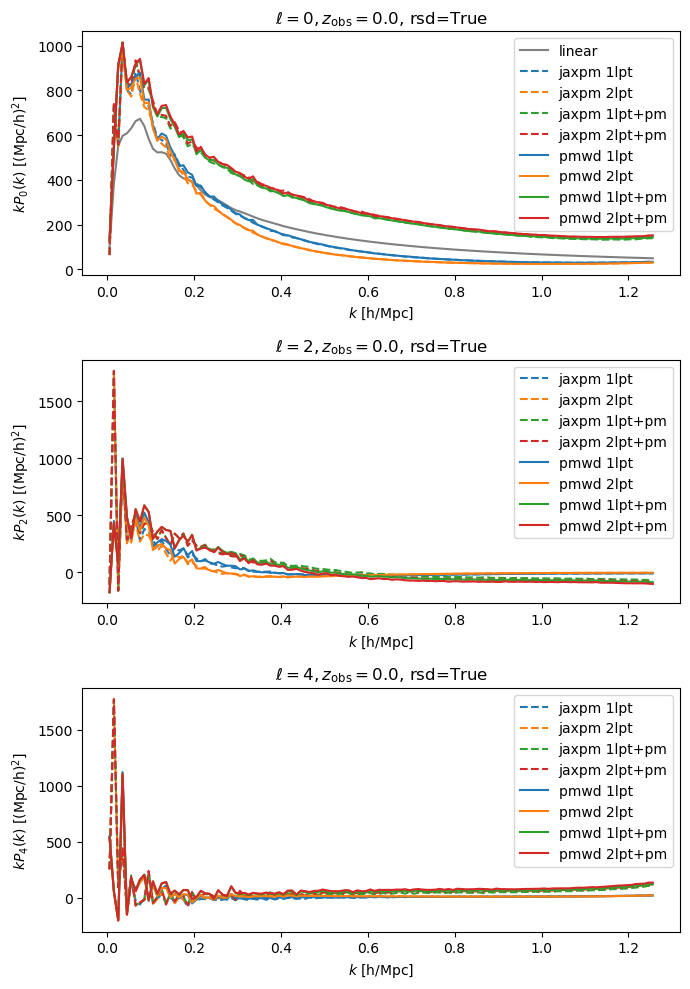

In [6]:
plot_ratio = False
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(x)+jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)/(jnp.abs(y))
# relerr = lambda x, y: jnp.abs(x-y)
relerr = lambda x, y: jnp.abs(x)/jnp.abs(y)

plt.figure(figsize=(7,10))
for i_pole, multipole in enumerate(multipoles):
    plt.subplot(len(multipoles), 1, i_pole+1)
    plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[i_pole+1], *args, **kwargs)
    # plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.plot(pk1[0], pk1[0]*relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)
    plot2_fn = lambda pk1, pk2, *args, **kwargs: plt.semilogy(pk1[0], relerr(pk2[i_pole+1], pk1[i_pole+1]), *args, **kwargs)
    # plot_fn = lambda pk, *args, **kwargs: plt.loglog(pk[0], pk[i_pole+1], *args, **kwargs)

    if plot_ratio:
        plt.hlines(1, 0, pk_jlpt1[0].max(), 'k')
        plot2_fn(pk_jlpt1, pk_lptwd1, 'C0', label=f"1lpt")
        plot2_fn(pk_jlpt2, pk_lptwd2, 'C1', label=f"2lpt")
        plot2_fn(pk_jpm1, pk_pmwd1, 'C2', label=f"1lpt+pm")
        plot2_fn(pk_jpm2, pk_pmwd2, 'C3', label=f"2lpt+pm")
        plt.ylabel(f"$\\hat P_{multipole}/P_{multipole}(k)$")
        # plt.ylim(1/3, 3)
    else:
        if multipole == 0:
            plot_fn(pk_lin_obs, 'grey', label=f"linear")

        plot_fn(pk_jlpt1, '--C0', label=f"jaxpm 1lpt")
        plot_fn(pk_jlpt2, '--C1', label=f"jaxpm 2lpt")
        plot_fn(pk_jpm1, '--C2', label=f"jaxpm 1lpt+pm")
        plot_fn(pk_jpm2, '--C3', label=f"jaxpm 2lpt+pm")

        plot_fn(pk_lptwd1, 'C0', label=f"pmwd 1lpt")    
        plot_fn(pk_lptwd2, 'C1', label=f"pmwd 2lpt")
        plot_fn(pk_pmwd1, 'C2', label=f"pmwd 1lpt+pm")    
        plot_fn(pk_pmwd2, 'C3', label=f"pmwd 2lpt+pm")
        plt.ylabel(f"$k P_{multipole}(k)$ [(Mpc/h)$^2$]")  


    plt.legend()
    plt.xlabel("$k$ [h/Mpc]"),
    plt.title("$\\ell="+f"{multipole}, "+"z_{\\text{obs}}="+f"{1/a_obs-1:.1f}$, rsd={rsd}")
plt.tight_layout()
mlflow.log_figure(plt.gcf(), f"pkl_a{a_lpt:.2f}-{a_obs:.2f}_mesh{mesh_length:d}_rsd{rsd:b}_ratio{plot_ratio:b}.svg")
# plt.savefig('pkl_history.svg', dpi=200, bbox_inches='tight')
plt.show();

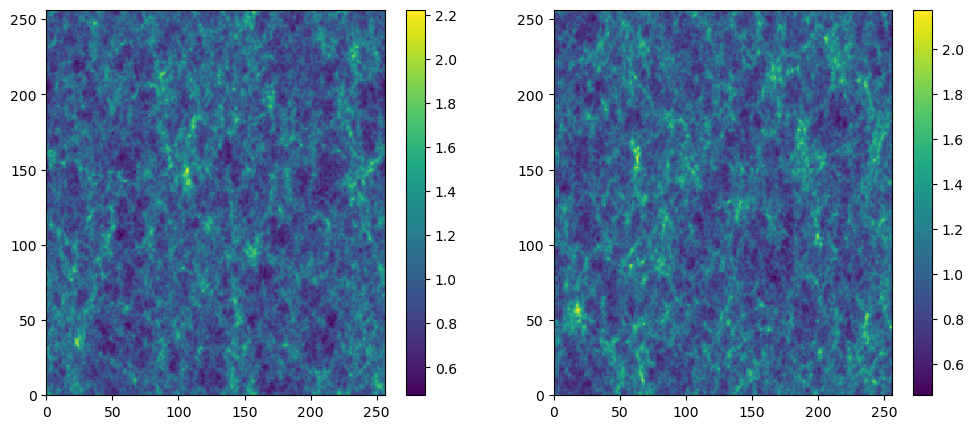

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.pcolormesh((res).mean(axis=0))
plt.colorbar()
plt.subplot(122)
plt.pcolormesh((res_pmwd).mean(axis=1)[::-1,::-1])
plt.colorbar()

In [8]:
from jax import jit, checkpoint, ensure_compile_time_eval
import jax.numpy as jnp
from pmwd.particles import Particles
from pmwd.cosmology import E2
from pmwd.boltzmann import growth
from pmwd.gravity import laplace, neg_grad
from pmwd.pm_util import fftfreq, fftfwd, fftinv


def _strain(kvec, i, j, pot, conf):
    """LPT strain component sourced by scalar potential only.

     The Nyquist planes are not zeroed when i == j.

    .. _Notes on FFT-based differentiation:
        https://math.mit.edu/~stevenj/fft-deriv.pdf

    """
    k_i, k_j = kvec[i], kvec[j]

    nyquist = jnp.pi / conf.ptcl_spacing
    eps = nyquist * jnp.finfo(conf.float_dtype).eps

    #TODO test if more accurate
    if i != j:
        k_i = jnp.where(jnp.abs(jnp.abs(k_i) - nyquist) <= eps, 0, k_i)
        k_j = jnp.where(jnp.abs(jnp.abs(k_j) - nyquist) <= eps, 0, k_j)

    strain = -k_i * k_j * pot

    strain = fftinv(strain, shape=conf.ptcl_grid_shape)
    strain = strain.astype(conf.float_dtype)  # no jnp.complex32

    return strain


def _L(kvec, pot_m, pot_n, conf):
    m_eq_n = pot_n is None
    if m_eq_n:
        pot_n = pot_m

    L = jnp.zeros(conf.ptcl_grid_shape, dtype=conf.float_dtype)

    for i in range(conf.dim):
        strain_m = _strain(kvec, i, i, pot_m, conf)

        for j in range(conf.dim-1, i, -1):
            strain_n = _strain(kvec, j, j, pot_n, conf)

            L += strain_m * strain_n

        if not m_eq_n:
            for j in range(i-1, -1, -1):
                strain_n = _strain(kvec, j, j, pot_n, conf)

                L += strain_m * strain_n

    if not m_eq_n:
        L *= 0.5

    # Assuming strain sourced by scalar potential only, symmetric about ``i`` and ``j``,
    # for lpt_order <=3, i.e., m, n <= 2
    for i in range(conf.dim-1):
        for j in range(i+1, conf.dim):
            strain_m = _strain(kvec, i, j, pot_m, conf)

            strain_n = strain_m
            if not m_eq_n:
                strain_n = _strain(kvec, j, i, pot_n, conf)

            L -= strain_m * strain_n

    return L


@jit
@checkpoint
def lpt(modes, cosmo, conf):
    """Lagrangian perturbation theory at ``conf.lpt_order``.

    Parameters
    ----------
    modes : jax.Array
        Linear matter overdensity Fourier modes in [L^3].
    cosmo : Cosmology
    conf : Configuration

    Returns
    -------
    ptcl : Particles
    obsvbl : Observables

    Raises
    ------
    ValueError
        If ``conf.dim`` or ``conf.lpt_order`` is not supported.

    """
    if conf.dim not in (1, 2, 3):
        raise ValueError(f'dim={conf.dim} not supported')
    if conf.lpt_order not in (0, 1, 2, 3):
        raise ValueError(f'lpt_order={conf.lpt_order} not supported')

    modes /= conf.ptcl_cell_vol  # remove volume factor first for convenience

    kvec = fftfreq(conf.ptcl_grid_shape, conf.ptcl_spacing, dtype=conf.float_dtype)

    pot = []

    if conf.lpt_order > 0:
        src_1 = modes

        pot_1 = laplace(kvec, src_1, cosmo)
        pot.append(pot_1)

    if conf.lpt_order > 1:
        src_2 = _L(kvec, pot_1, None, conf)

        src_2 = fftfwd(src_2)

        pot_2 = laplace(kvec, src_2, cosmo)
        pot.append(pot_2)

    if conf.lpt_order > 2:
        raise NotImplementedError('TODO')

    a = conf.a_start
    ptcl = Particles.gen_grid(conf, vel=True)
    disp = jnp.zeros_like(ptcl.disp)
    vel = jnp.zeros_like(ptcl.vel)

    for order in range(1, 1+conf.lpt_order):
        D = growth(a, cosmo, conf, order=order)
        dD_dlna = growth(a, cosmo, conf, order=order, deriv=1)
        a2HDp = a**2 * jnp.sqrt(E2(a, cosmo)) * dD_dlna
        D = D.astype(conf.float_dtype)
        dD_dlna = dD_dlna.astype(conf.float_dtype)
        a2HDp = a2HDp.astype(conf.float_dtype)

        for i, k in enumerate(kvec):
            grad = neg_grad(k, pot[order-1], conf.ptcl_spacing)

            grad = fftinv(grad, shape=conf.ptcl_grid_shape)
            grad = grad.astype(conf.float_dtype)  # no jnp.complex32

            grad = grad.ravel()

            disp = disp.at[:, i].add(D * grad)
            vel = vel.at[:, i].add(a2HDp * grad)

    return disp/conf.ptcl_spacing, vel/conf.ptcl_spacing

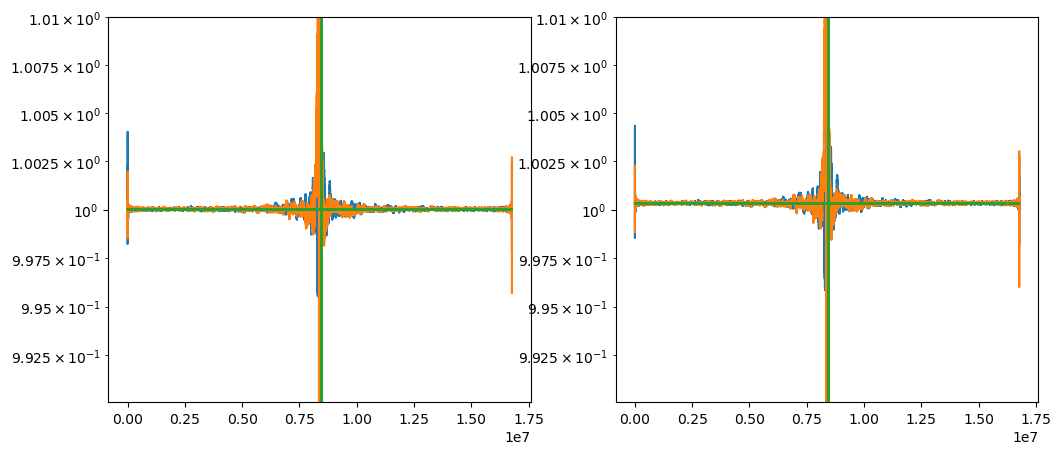

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.semilogy(jnp.abs(jnp.sort(res[0], 0)/jnp.sort(res_pmwd[0], 0)))
plt.ylim(1/1.01,1.01)
plt.subplot(122)
plt.semilogy(jnp.abs(jnp.sort(res[1], 0)/jnp.sort(res_pmwd[1], 0)))
plt.ylim(1/1.01,1.01)
plt.show();